In [ ]:
import sys
sys.path.insert(1, "drive/MyDrive/colab_notebook_data/")

import data_bert
import model_bert_evaluation_pipeline
import model_bert_tree_evaluation_pipeline
import model_bert_evaluation_helpers
import config
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
topics = data_bert.topics
topics_inv_map = pd.Series(data=np.arange(len(topics)), index=topics.index)
topic_trees = []
total_nodes = []
total_nodes_by_tid = np.empty(shape = len(topics), dtype="object")
for str_id in topics.loc[topics["level"] == 0].index:
    node = model_bert_tree_evaluation_pipeline.Node(level=0, topic_num_id=topics_inv_map[str_id], topic_str_id=str_id)
    topic_trees.append(node)
    total_nodes.append(node)
    total_nodes_by_tid[topics_inv_map[str_id]] = node

# generate tree structure
for level in range(np.max(topics["level"].unique())):
    for str_id in topics.loc[topics["level"] == (level + 1)].index:
        parent = model_bert_tree_evaluation_pipeline.find_node_by_str_id(total_nodes, topics.loc[str_id, "parent"])

        node = model_bert_tree_evaluation_pipeline.Node(level=(level+1), topic_num_id=topics_inv_map[str_id], topic_str_id=str_id)
        node.parent = parent
        parent.children.append(node)

        total_nodes.append(node)
        total_nodes_by_tid[node.topic_num_id] = node

topic_id_to_preorder_id = np.zeros(shape=len(total_nodes), dtype=np.int32)
topic_id_to_subtree_end = np.zeros(shape=len(total_nodes), dtype=np.int32)
preorder_id_to_topic_id = np.zeros(shape=len(total_nodes), dtype=np.int32)

cur_id = 0
for node in topic_trees:
    cur_id = model_bert_tree_evaluation_pipeline.compute_preorder_id(node, cur_id, topic_id_to_preorder_id, preorder_id_to_topic_id, topic_id_to_subtree_end) + 1

def compute_expanded_tree(node, min_subtree_size):
    for child in node.children:
        compute_expanded_tree(child, min_subtree_size)
    
    if node.subtree_end_id - node.preorder_id < min_subtree_size:
        cnode = node
        while cnode.parent is not None:
            cnode = cnode.parent
            if cnode.subtree_end_id - cnode.preorder_id >= min_subtree_size:
                break
        node.least_subtree = cnode
    else:
        node.least_subtree = node

# Compute per overshoot recall values

In [ ]:
mapping_dict = {}
for min_expand in range(1,30):
    for node in topic_trees:
        compute_expanded_tree(node, min_expand)
    mapping = np.zeros(shape = len(data_bert.topics), dtype=np.int32)
    for k in range(len(data_bert.topics)):
        topic_str_id = data_bert.topics.index[k]
        node = total_nodes_by_tid[k]
        mapping[k] = node.least_subtree.topic_num_id
    mapping_dict[min_expand] = mapping

def compute_per_overshoot_recall_vals(folder_name):
  folder = config.resources_path + "model_eval_tree/" + folder_name + "/"
  cors_arr = np.empty(shape = len(topics), dtype = "object")
  for k in range(len(topics)):
    if os.path.isfile(folder + str(k) + ".npy"):
        row_preds = set(list(np.load(folder + str(k) + ".npy")))
    else:
        row_preds = set()
    cors_arr[k] = row_preds

  dframe = model_bert_evaluation_helpers.evaluate_quality_from_cors_arr(mapping_dict, data_bert.train_topics_num_id,
                                                                    data_bert.train_contents_num_id, cors_arr)
  display(dframe)
  dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
  plt.show()
  dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
  plt.show()
  dframe[["restriction_ratio"]].plot(figsize = (10, 10))
  plt.show()

  for k in range(len(topics)):
    x = cors_arr[k]
    cors_arr[k] = None
    del x
  del cors_arr

def compute_per_overshoot_recall_vals_zip(zip_name, test_or_train = "train"):
  zip_filename = config.resources_path + "model_eval_tree/" + zip_name
  cors_arr = np.empty(shape = len(topics), dtype = "object")
  ctime = time.time()

  npzip = np.load(zip_filename)
  print(npzip.keys())
  for k in range(len(topics)):
    if str(k) in npzip.keys():
        row_preds = set(list(npzip[str(k)]))
    else:
        row_preds = set()
    cors_arr[k] = row_preds
    if k % 3000 == 0:
      ctime = time.time() - ctime
      print(k, "    time: ", ctime)
      ctime = time.time()

  if test_or_train == "train":
    dframe = model_bert_evaluation_helpers.evaluate_quality_from_cors_arr(mapping_dict, data_bert.train_topics_num_id,
                                                                    data_bert.train_contents_num_id, cors_arr)
  else:
    dframe = model_bert_evaluation_helpers.evaluate_quality_from_cors_arr(mapping_dict, data_bert.test_topics_num_id,
                                                                    data_bert.test_contents_num_id, cors_arr)
  display(dframe)
  dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
  plt.show()
  dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
  plt.show()
  dframe[["restriction_ratio"]].plot(figsize = (10, 10))
  plt.show()

  for k in range(len(topics)):
    x = cors_arr[k]
    cors_arr[k] = None
    del x
  del cors_arr

### overshoot_small_trained_in_train_eval_test

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f5cb9630790>)
0     time:  1.7190425395965576
3000     time:  1.1142044067382812
6000     time:  1.1770741939544678
9000     time:  0.9428179264068604
12000     time:  1.052603006362915
15000     time:  1.155808448791504
18000     time:  1.1278114318847656
21000     time:  1.0431129932403564
24000     time:  1.0615081787109375
27000     time:  1.0591487884521484
30000     time:  1.1524908542633057
33000     time:  1.0269684791564941
36000     time:  1.0570459365844727
39000     time:  0.9969944953918457
42000     time:  1.0829555988311768
45000     time:  1.0134680271148682
48000     time:  0.9223999977111816
51000     time:  0.9424681663513184
54000     time:  0.9468979835510254
57000     time:  1.0263562202453613
60000     time:  1.0323281288146973
63000     time:  1.1389636993408203
66000     time:  1.0654370784759521
69000     time:  1.0635311603546143
72000     time:  1.0311691761016846
75000     time:  1.1285338401794434
Computed met

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
1,0.198476,0.003859,0.975133,0.004077,0.010295,0.000029,0.000143,0.975133,0.024799
2,0.942529,0.001088,0.872834,0.005254,0.928388,0.000509,0.002537,0.872834,0.127226
3,0.946549,0.000950,0.860684,0.004653,0.934201,0.000467,0.002331,0.860684,0.139377
4,0.952154,0.000851,0.841534,0.004187,0.941136,0.000414,0.002065,0.841534,0.158527
5,0.958160,0.000748,0.814694,0.003689,0.948968,0.000357,0.001781,0.814694,0.185369
6,0.963049,0.000653,0.789203,0.003221,0.954913,0.000316,0.001576,0.789203,0.210860
7,0.967779,0.000567,0.764531,0.002805,0.960131,0.000284,0.001419,0.764531,0.235533
8,0.971346,0.000503,0.743748,0.002493,0.964068,0.000262,0.001309,0.743748,0.256317
9,0.974294,0.000459,0.726753,0.002275,0.967166,0.000247,0.001232,0.726753,0.273312
10,0.976386,0.000412,0.709338,0.002044,0.970255,0.000233,0.001162,0.709338,0.290727


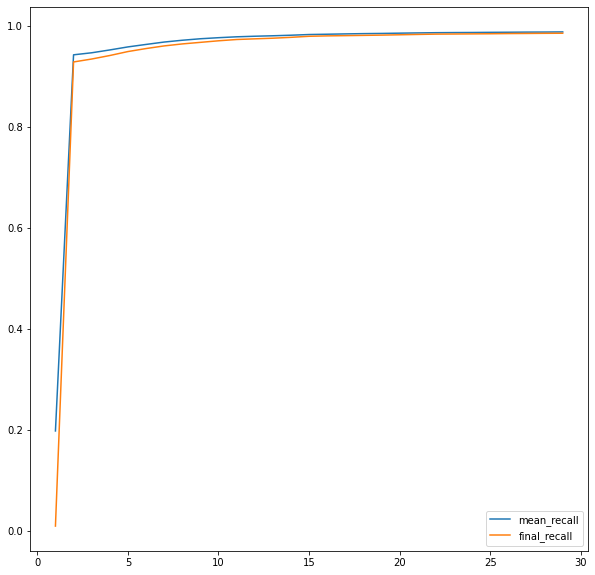

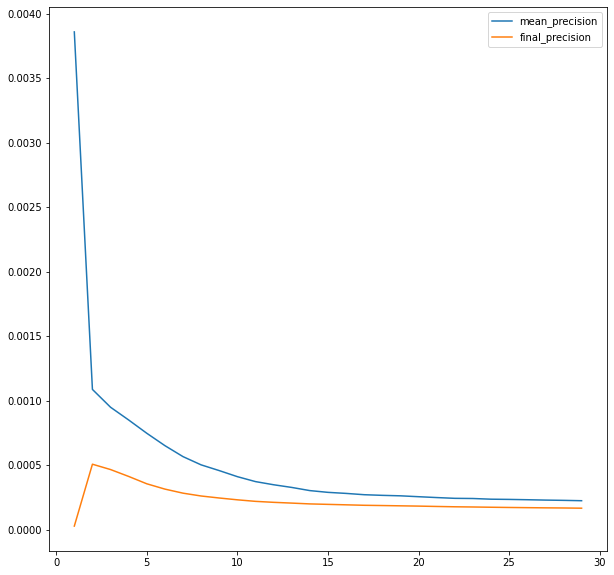

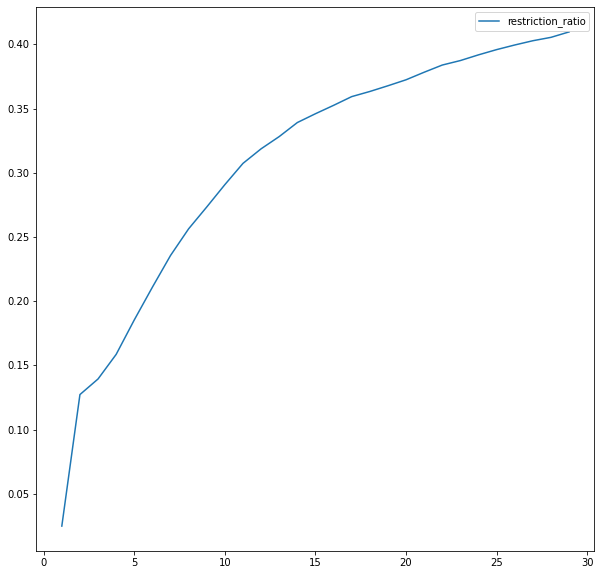

In [ ]:
compute_per_overshoot_recall_vals_zip("overshoot_small_trained_in_train_eval_test_new.zip", "test")

### overshoot_small_trained_in_train_eval_train

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f1364d8fac0>)
0     time:  1.9116594791412354
3000     time:  12.321518421173096
6000     time:  10.090027093887329
9000     time:  9.138576030731201
12000     time:  9.40385365486145
15000     time:  9.471790075302124
18000     time:  9.995026588439941
21000     time:  9.985378742218018
24000     time:  9.872317552566528
27000     time:  10.60168743133545
30000     time:  9.98932957649231
33000     time:  9.81702184677124
36000     time:  10.078238725662231
39000     time:  10.062446355819702
42000     time:  10.454661846160889
45000     time:  10.471827745437622
48000     time:  10.051649332046509
51000     time:  9.763198375701904
54000     time:  10.124947309494019
57000     time:  9.970882415771484
60000     time:  10.044572591781616
63000     time:  9.966728925704956
66000     time:  9.914239406585693
69000     time:  9.653642654418945
72000     time:  10.007905006408691
75000     time:  9.714271306991577
Computed metrics of 0 out of

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
1,0.996646,0.009044,0.984593,0.039117,0.998680,0.002512,0.012433,0.984593,0.015445
2,0.998661,0.002234,0.969634,0.010838,0.999489,0.001277,0.006352,0.969634,0.030405
3,0.998773,0.001992,0.965303,0.009704,0.999584,0.001118,0.005564,0.965303,0.034736
4,0.998833,0.001805,0.960570,0.008809,0.999613,0.000984,0.004900,0.960570,0.039469
5,0.998853,0.001613,0.955591,0.007885,0.999619,0.000874,0.004353,0.955591,0.044448
6,0.998954,0.001422,0.950435,0.006971,0.999649,0.000783,0.003902,0.950435,0.049603
7,0.998995,0.001293,0.946408,0.006344,0.999661,0.000724,0.003610,0.946408,0.053631
8,0.998999,0.001161,0.942564,0.005705,0.999667,0.000676,0.003369,0.942564,0.057475
9,0.999059,0.001061,0.939141,0.005221,0.999685,0.000638,0.003180,0.939141,0.060898
10,0.999059,0.000968,0.935583,0.004769,0.999685,0.000602,0.003005,0.935583,0.064456


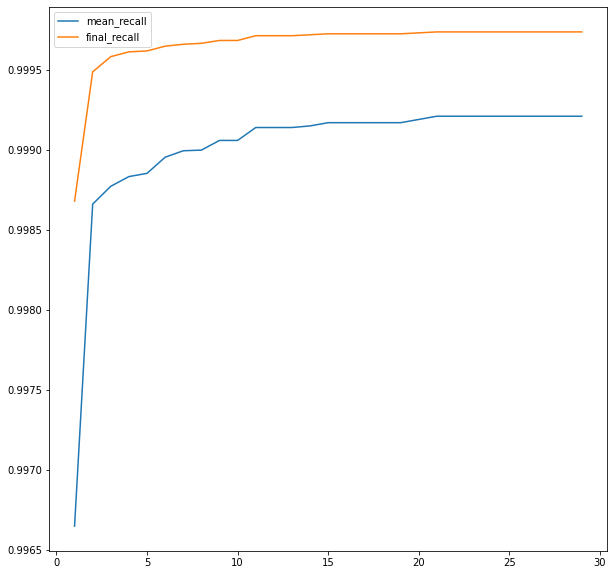

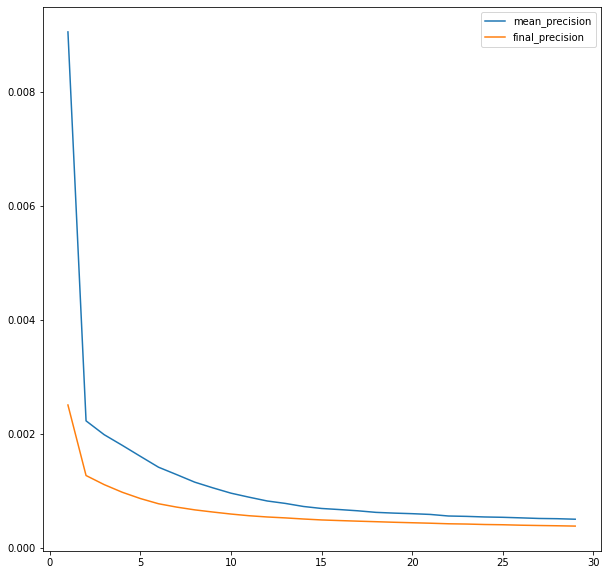

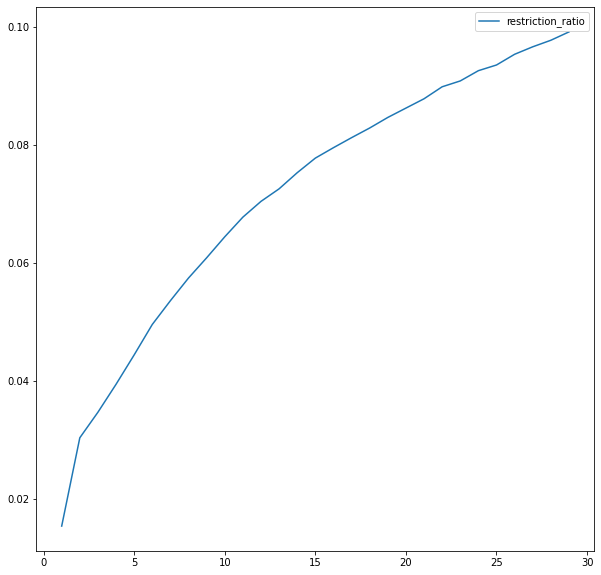

In [ ]:
compute_per_overshoot_recall_vals_zip("overshoot_small_trained_in_train_eval_train.zip", "train")

### overshoot_small_trained_in_test_eval_train

In [ ]:
compute_per_overshoot_recall_vals_zip("overshoot_small_trained_in_test_eval_train.zip", "train")

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f1d1e4c6d00>)
0     time:  1.3536229133605957
3000     time:  15.23497223854065
6000     time:  11.843486309051514
9000     time:  11.621514081954956
12000     time:  11.450966119766235
15000     time:  12.022696018218994
18000     time:  11.900502443313599
21000     time:  11.800032138824463
24000     time:  12.522253513336182
27000     time:  11.991886615753174
30000     time:  11.464771270751953
33000     time:  11.300854921340942
36000     time:  11.279183626174927
39000     time:  11.447412967681885
42000     time:  12.051371812820435
45000     time:  11.944544553756714
48000     time:  12.101686954498291
51000     time:  12.04439091682434
54000     time:  12.355401515960693
57000     time:  12.26183795928955
60000     time:  12.021259307861328
63000     time:  12.028198003768921
66000     time:  12.127001762390137
69000     time:  13.520930051803589


### overshoot_trained_in_train_eval_test

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f9b25290cd0>)
0     time:  2.8776700496673584
3000     time:  6.793426752090454
6000     time:  4.111618280410767
9000     time:  4.016761302947998
12000     time:  4.438919305801392
15000     time:  4.5322113037109375
18000     time:  4.699549674987793
21000     time:  4.273079872131348
24000     time:  4.337777614593506
27000     time:  4.342895030975342
30000     time:  4.356210470199585
33000     time:  4.336283206939697
36000     time:  4.315501928329468
39000     time:  4.229934930801392
42000     time:  4.20599889755249
45000     time:  4.171782970428467
48000     time:  4.013829231262207
51000     time:  3.9781596660614014
54000     time:  4.144644498825073
57000     time:  4.331099033355713
60000     time:  4.1126930713653564
63000     time:  4.429851293563843
66000     time:  4.161864280700684
69000     time:  4.137739896774292
72000     time:  4.15782618522644
75000     time:  4.311978578567505
Computed metrics of 0 out of 25338

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
1,0.832531,0.006302,0.957408,0.025388,0.787323,0.001287,0.006394,0.957408,0.042632
2,0.939141,0.001225,0.893842,0.005873,0.923523,0.000606,0.003022,0.893842,0.106217
3,0.942698,0.001066,0.882803,0.005212,0.929155,0.000552,0.002755,0.882803,0.117257
4,0.948107,0.000957,0.865289,0.004704,0.936109,0.000484,0.002416,0.865289,0.134771
5,0.954740,0.000844,0.840973,0.004155,0.944254,0.000414,0.002065,0.840973,0.159089
6,0.959889,0.000736,0.817686,0.003627,0.950119,0.000363,0.001813,0.817686,0.182377
7,0.964888,0.000642,0.795109,0.003175,0.955155,0.000325,0.001622,0.795109,0.204954
8,0.967926,0.000567,0.775561,0.002805,0.958718,0.000298,0.001486,0.775561,0.224503
9,0.970896,0.000517,0.759634,0.002561,0.961968,0.000279,0.001393,0.759634,0.240430
10,0.972770,0.000467,0.743780,0.002318,0.964582,0.000262,0.001310,0.743780,0.256285


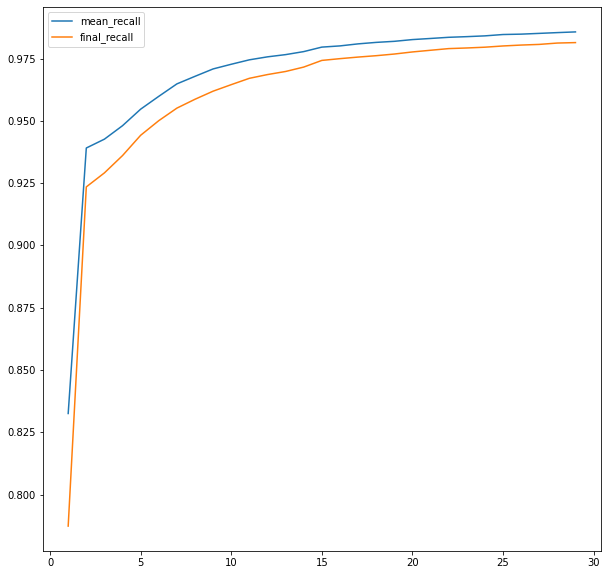

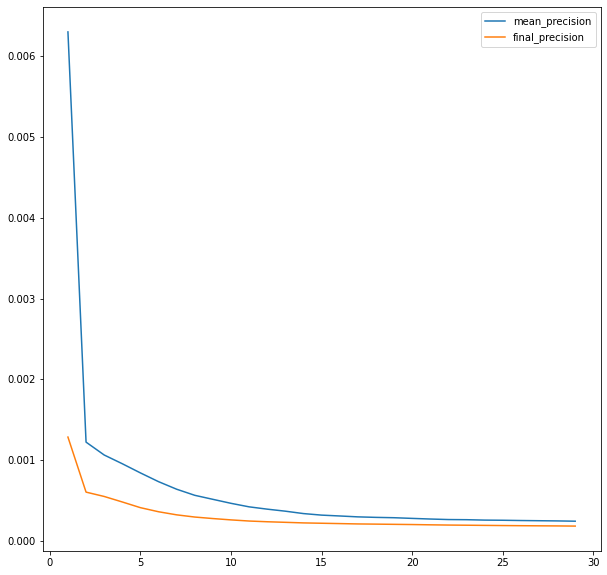

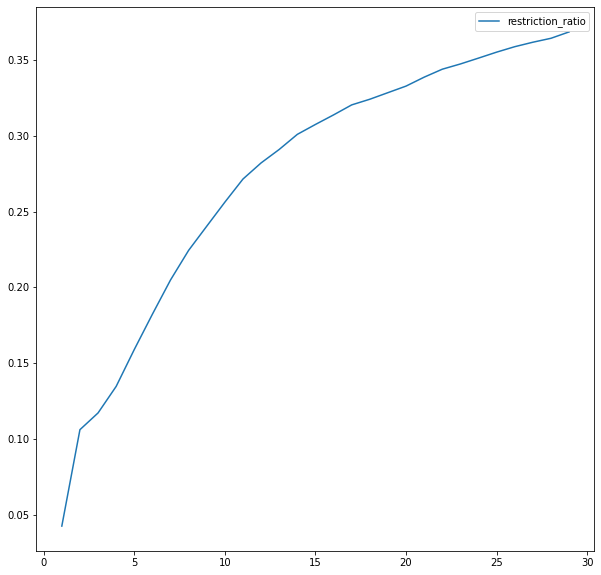

In [ ]:
compute_per_overshoot_recall_vals_zip("topics_tree_overshoot_trained_on_train_eval_test.zip", "test")

### overshoot_trained_in_test_eval_train

In [ ]:
compute_per_overshoot_recall_vals_zip("overshoot_small_trained_in_test_eval_train.zip", "train")

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f6b4cf214f0>)
0     time:  1.4458317756652832
3000     time:  16.962379455566406
6000     time:  11.52625298500061
9000     time:  11.434374809265137
12000     time:  11.160014867782593
15000     time:  12.057820320129395
18000     time:  11.514454126358032
21000     time:  11.99073052406311
24000     time:  12.353458404541016
27000     time:  12.665677309036255
30000     time:  12.766647100448608
33000     time:  12.514331579208374
36000     time:  11.604756355285645
39000     time:  12.092514038085938
42000     time:  12.146584033966064
45000     time:  12.29271674156189
48000     time:  12.233235597610474
51000     time:  12.082788228988647
54000     time:  11.776557683944702
57000     time:  12.01295018196106
60000     time:  11.990195035934448
63000     time:  11.531333446502686
66000     time:  12.061185598373413
69000     time:  14.85335636138916


### overshoot_trained_in_train_eval_train

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f9b26913430>)
0     time:  2.212162971496582
3000     time:  12.47382140159607
6000     time:  8.147298336029053
9000     time:  7.798383951187134
12000     time:  8.679934024810791
15000     time:  8.173773050308228
18000     time:  8.499887943267822
21000     time:  8.470613479614258
24000     time:  8.842549562454224
27000     time:  8.677962064743042
30000     time:  8.211342811584473
33000     time:  8.475753784179688
36000     time:  8.671419620513916
39000     time:  8.422414302825928
42000     time:  8.236980438232422
45000     time:  8.067975521087646
48000     time:  8.32311487197876
51000     time:  8.308173894882202
54000     time:  8.212010145187378
57000     time:  8.1943998336792
60000     time:  8.079280614852905
63000     time:  8.11082935333252
66000     time:  8.484622240066528
69000     time:  8.358426809310913
72000     time:  8.686666488647461
75000     time:  8.673348188400269
Computed metrics of 0 out of 49523
0.000

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
1,0.998472,0.009633,0.986384,0.041873,0.999417,0.002843,0.014056,0.986384,0.013654
2,0.999423,0.002552,0.973005,0.012319,0.999762,0.001437,0.007142,0.973005,0.027034
3,0.999493,0.002271,0.969210,0.011019,0.999839,0.001260,0.006267,0.969210,0.030829
4,0.999533,0.002064,0.964979,0.010031,0.999851,0.001108,0.005515,0.964979,0.035059
5,0.999553,0.001845,0.960576,0.008987,0.999857,0.000984,0.004902,0.960576,0.039463
6,0.999553,0.001633,0.956005,0.007973,0.999857,0.000882,0.004395,0.956005,0.044034
7,0.999573,0.001483,0.952391,0.007252,0.999863,0.000815,0.004062,0.952391,0.047648
8,0.999594,0.001327,0.948933,0.006504,0.999869,0.000760,0.003788,0.948933,0.051106
9,0.999614,0.001216,0.945858,0.005966,0.999875,0.000717,0.003574,0.945858,0.054181
10,0.999614,0.001112,0.942627,0.005462,0.999875,0.000677,0.003373,0.942627,0.057412


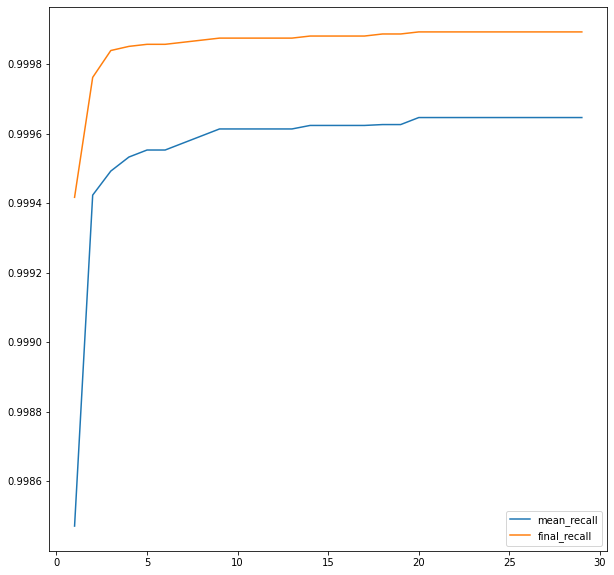

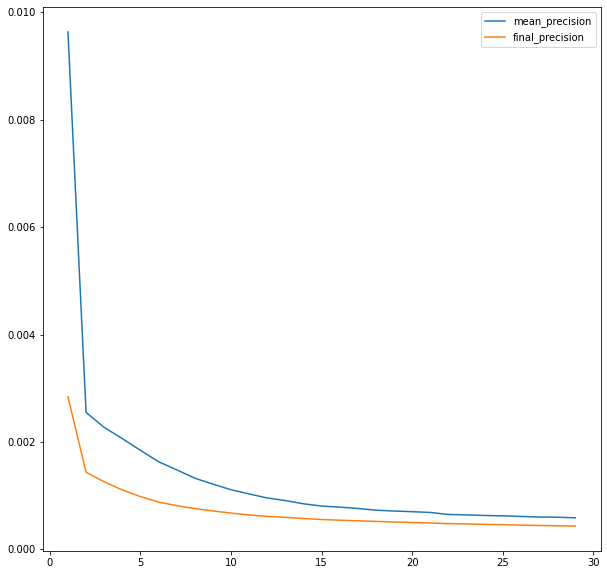

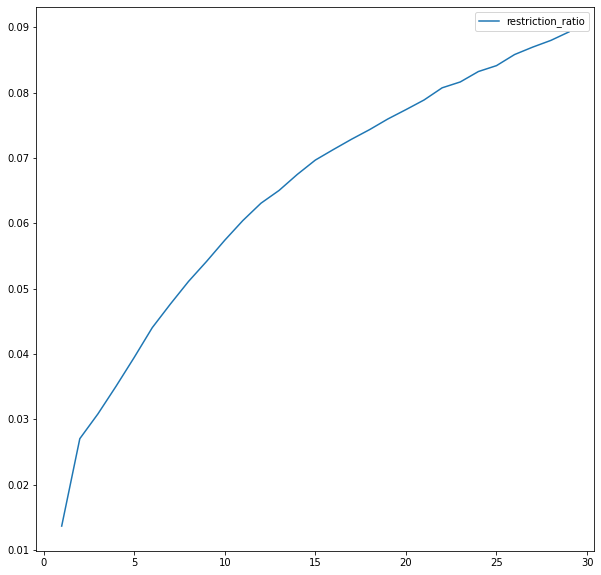

In [ ]:
compute_per_overshoot_recall_vals_zip("topics_tree_overshoot_trained_on_train_eval_train.zip", "train")

In [ ]:
raise Exception("stopping")

# Generate combined overshoot data

In [ ]:
# seems best to pick 2 as the overshoot.
expand = 2
for node in topic_trees:
    compute_expanded_tree(node, expand)
mapping = np.zeros(shape = len(data_bert.topics), dtype=np.int32)
for k in range(len(data_bert.topics)):
    topic_str_id = data_bert.topics.index[k]
    node = total_nodes_by_tid[k]
    mapping[k] = node.least_subtree.topic_num_id

In [ ]:
train_stuff_folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_in_train_eval_train/"
test_stuff_folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_in_train_eval_test/"

In [ ]:
mfolder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_in_train_eval_train_COMBINE/"

if not os.path.isdir(mfolder):
    os.mkdir(mfolder)

mtopics = []
mcontents = []
saved_files_lengths = []
saved_files = 0

for topic_num_id in data_bert.train_topics_num_id:
    mapped_id = mapping[topic_num_id]
    if os.path.isfile(train_stuff_folder + str(mapped_id) + ".npy"):
        cors = np.load(train_stuff_folder + str(mapped_id) + ".npy")
        mcontents.extend(list(cors))
        mtopics.extend(list(np.repeat(topic_num_id, len(cors))))
        if len(mcontents) > 67108864:
            assert len(mcontents) == len(mtopics)
            np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
            np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
            saved_files_lengths.append(len(mcontents))
            saved_files += 1
            
            del mtopics, mcontents
            mtopics = []
            mcontents = []

np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
saved_files_lengths.append(len(mcontents))
saved_files += 1
del mtopics, mcontents
np.save(mfolder + "saved_files_lengths.npy", np.array(saved_files_lengths, dtype=np.int32))

In [ ]:
mfolder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_in_train_eval_test_COMBINE/"

if not os.path.isdir(mfolder):
    os.mkdir(mfolder)

mtopics = []
mcontents = []
saved_files_lengths = []
saved_files = 0

for topic_num_id in data_bert.test_topics_num_id:
    mapped_id = mapping[topic_num_id]
    if os.path.isfile(test_stuff_folder + str(mapped_id) + ".npy"):
        cors = np.load(test_stuff_folder + str(mapped_id) + ".npy")
        mcontents.extend(list(cors))
        mtopics.extend(list(np.repeat(topic_num_id, len(cors))))
        if len(mcontents) > 67108864:
            assert len(mcontents) == len(mtopics)
            np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
            np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
            saved_files_lengths.append(len(mcontents))
            saved_files += 1
            
            del mtopics, mcontents
            mtopics = []
            mcontents = []

np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
saved_files_lengths.append(len(mcontents))
saved_files += 1
del mtopics, mcontents
np.save(mfolder + "saved_files_lengths.npy", np.array(saved_files_lengths, dtype=np.int32))

In [ ]:
train_stuff_folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_in_test_eval_train/"
mfolder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_in_test_eval_train_COMBINE/"

if not os.path.isdir(mfolder):
    os.mkdir(mfolder)

mtopics = []
mcontents = []
saved_files_lengths = []
saved_files = 0

for topic_num_id in data_bert.train_topics_num_id:
    mapped_id = mapping[topic_num_id]
    if os.path.isfile(train_stuff_folder + str(mapped_id) + ".npy"):
        cors = np.load(train_stuff_folder + str(mapped_id) + ".npy")
        mcontents.extend(list(cors))
        mtopics.extend(list(np.repeat(topic_num_id, len(cors))))
        if len(mcontents) > 67108864:
            assert len(mcontents) == len(mtopics)
            np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
            np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
            saved_files_lengths.append(len(mcontents))
            saved_files += 1
            
            del mtopics, mcontents
            mtopics = []
            mcontents = []

np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
saved_files_lengths.append(len(mcontents))
saved_files += 1
del mtopics, mcontents
np.save(mfolder + "saved_files_lengths.npy", np.array(saved_files_lengths, dtype=np.int32))

# Compute topk tuned mpnet with tree overshootings

In [ ]:
def compute_intersection_recall_vals_zip_double(zip_name, topk_vals, test_or_train = "test", topk_mpnet_restriction_file = "GENERATED_TOPK_PREDS_FROM_MPNET.npy",
                                         topk_mpnet_tree_restriction_file = "GENERATED_TOPK_PREDS_FROM_MPNET_TREE.npy"):
  topk_preds = np.load(config.resources_path + topk_mpnet_restriction_file)
  topk_preds_tree = np.load(config.resources_path + topk_mpnet_tree_restriction_file)
  zip_filename = config.resources_path + "model_eval_tree/" + zip_name
  cors_arr = np.empty(shape = len(data_bert.topics), dtype = "object")
  ctime = time.time()

  npzip = np.load(zip_filename)
  print(npzip.keys())

  if test_or_train == "test":
    topics_restrict = data_bert.test_topics_num_id
  else:
    topics_restrict = data_bert.train_topics_num_id

  for k in range(len(data_bert.topics)):
    if str(k) in npzip.keys():
        row_preds = npzip[str(k)]
        left = np.searchsorted(topics_restrict, k, side="left")
        right = np.searchsorted(topics_restrict, k, side="right")
        if right > left:
          unqs = np.unique(topk_preds_tree[left, :])
          row_preds = row_preds[data_bert.fast_contains_multi(unqs, row_preds)]
        else:
          row_preds = np.array([], dtype=np.int32)
    else:
        row_preds = np.array([], dtype=np.int32)
    cors_arr[k] = row_preds
    if k % 3000 == 0:
      ctime = time.time() - ctime
      print(k, "    time: ", ctime)
      ctime = time.time()

  if test_or_train == "train":
    dframe = model_bert_evaluation_helpers.evaluate_diff_topk_intersection_quality(data_bert.train_topics_num_id,
                                                                    data_bert.train_contents_num_id, cors_arr, topk_preds, topk_vals)
  else:
    dframe = model_bert_evaluation_helpers.evaluate_diff_topk_intersection_quality(data_bert.test_topics_num_id,
                                                                    data_bert.test_contents_num_id, cors_arr, topk_preds, topk_vals)
  display(dframe)
  dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
  plt.show()
  dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
  plt.show()
  dframe[["restriction_ratio"]].plot(figsize = (10, 10))
  plt.show()

  for k in range(len(data_bert.topics)):
    x = cors_arr[k]
    cors_arr[k] = None
    del x
  del cors_arr

In [ ]:
def compute_intersection_recall_vals_zip(zip_name, topk_vals, test_or_train = "test", topk_mpnet_restriction_file = "GENERATED_TOPK_PREDS_FROM_MPNET.npy"):
  topk_preds = np.load(config.resources_path + topk_mpnet_restriction_file)
  zip_filename = config.resources_path + "model_eval_tree/" + zip_name
  cors_arr = np.empty(shape = len(data_bert.topics), dtype = "object")
  ctime = time.time()

  npzip = np.load(zip_filename)
  print(npzip.keys())
  for k in range(len(data_bert.topics)):
    if str(k) in npzip.keys():
        row_preds = npzip[str(k)]
    else:
        row_preds = np.array([], dtype=np.int32)
    cors_arr[k] = row_preds
    if k % 3000 == 0:
      ctime = time.time() - ctime
      print(k, "    time: ", ctime)
      ctime = time.time()

  if test_or_train == "train":
    dframe = model_bert_evaluation_helpers.evaluate_diff_topk_intersection_quality(data_bert.train_topics_num_id,
                                                                    data_bert.train_contents_num_id, cors_arr, topk_preds, topk_vals)
  else:
    dframe = model_bert_evaluation_helpers.evaluate_diff_topk_intersection_quality(data_bert.test_topics_num_id,
                                                                    data_bert.test_contents_num_id, cors_arr, topk_preds, topk_vals)
  display(dframe)
  dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
  plt.show()
  dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
  plt.show()
  dframe[["restriction_ratio"]].plot(figsize = (10, 10))
  plt.show()

  for k in range(len(data_bert.topics)):
    x = cors_arr[k]
    cors_arr[k] = None
    del x
  del cors_arr

def compute_intersection_recall_vals_zip_restrict(zip_name, topk_vals, test_or_train = "test", topk_mpnet_restriction_file = "GENERATED_TOPK_PREDS_FROM_MPNET.npy"):
  topk_preds = np.load(config.resources_path + topk_mpnet_restriction_file)
  zip_filename = config.resources_path + "model_eval_tree/" + zip_name
  cors_arr = np.empty(shape = len(data_bert.topics), dtype = "object")
  ctime = time.time()

  npzip = np.load(zip_filename)
  print(npzip.keys())
  for k in range(len(data_bert.topics)):
    if str(k) in npzip.keys():
        row_preds = npzip[str(k)]
    else:
        row_preds = np.array([], dtype=np.int32)
    cors_arr[k] = row_preds
    if k % 3000 == 0:
      ctime = time.time() - ctime
      print(k, "    time: ", ctime)
      ctime = time.time()

  if test_or_train == "train":
    dframe = model_bert_evaluation_helpers.evaluate_diff_topk_intersection_quality_restrict(data_bert.train_topics_num_id, data_bert.train_contents_num_id, cors_arr, topk_preds, topk_vals)
  else:
    dframe = model_bert_evaluation_helpers.evaluate_diff_topk_intersection_quality_restrict(data_bert.test_topics_num_id, data_bert.test_contents_num_id, cors_arr, topk_preds, topk_vals)
  display(dframe)
  dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
  plt.show()
  dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
  plt.show()
  dframe[["restriction_ratio"]].plot(figsize = (10, 10))
  plt.show()

  for k in range(len(data_bert.topics)):
    x = cors_arr[k]
    cors_arr[k] = None
    del x
  del cors_arr

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fb819acc070>)
0     time:  1.1603827476501465
3000     time:  4.167839527130127
6000     time:  3.9171249866485596
9000     time:  3.563889265060425
12000     time:  3.7762234210968018
15000     time:  3.9438042640686035
18000     time:  3.783564329147339
21000     time:  3.6965370178222656
24000     time:  3.851879119873047
27000     time:  3.7407705783843994
30000     time:  3.7059075832366943
33000     time:  3.869309186935425
36000     time:  3.8095881938934326
39000     time:  3.8745267391204834
42000     time:  3.8182404041290283
45000     time:  3.766150951385498
48000     time:  3.7917165756225586
51000     time:  3.690675735473633
54000     time:  3.77630615234375
57000     time:  3.7561447620391846
60000     time:  3.653991460800171
63000     time:  3.881222724914551
66000     time:  3.6993775367736816
69000     time:  3.7062036991119385
72000     time:  3.771587610244751
75000     time:  3.8682971000671387
Computed metrics of 0 

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
2,0.319118,0.251934,0.999915,0.155136,0.113571,0.256257,0.127803,0.999915,0.000031
4,0.377752,0.204012,0.999894,0.188427,0.176735,0.203749,0.181549,0.999894,0.000060
6,0.416974,0.176944,0.999872,0.203263,0.222892,0.174735,0.211248,0.999872,0.000089
8,0.445630,0.158346,0.999850,0.210521,0.258552,0.154236,0.227745,0.999850,0.000117
10,0.468602,0.144538,0.999826,0.213464,0.287863,0.139198,0.237197,0.999826,0.000144
12,0.487359,0.133697,0.999803,0.213976,0.311915,0.126943,0.241528,0.999803,0.000171
14,0.502572,0.124654,0.999778,0.212732,0.331739,0.116746,0.242444,0.999778,0.000198
16,0.515751,0.117116,0.999754,0.210790,0.349362,0.108457,0.241900,0.999754,0.000225
18,0.526780,0.110872,0.999730,0.208282,0.364946,0.101429,0.240158,0.999730,0.000251
20,0.537022,0.104980,0.999706,0.205256,0.378804,0.095404,0.237628,0.999706,0.000277


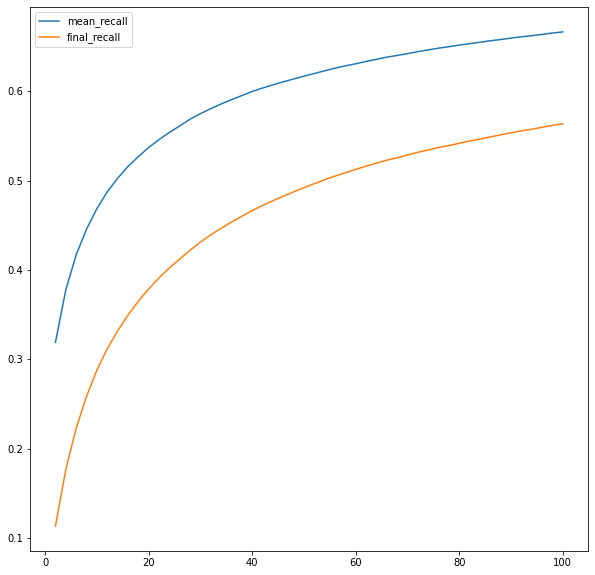

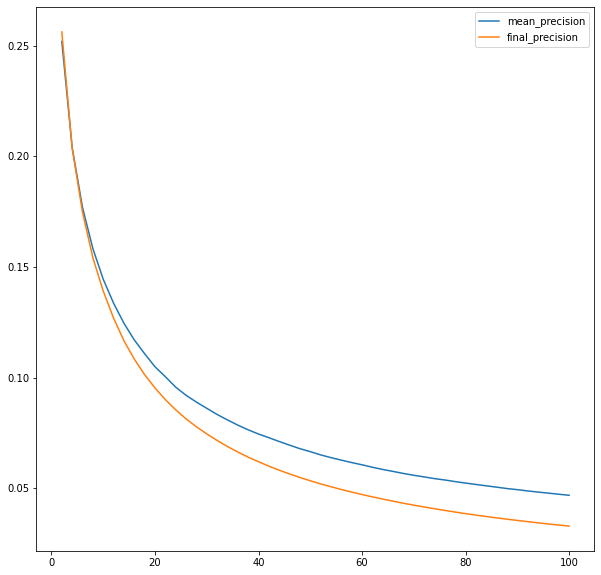

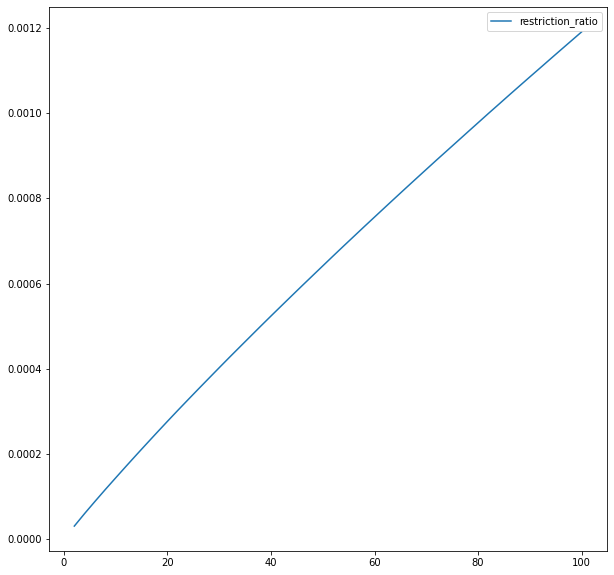

In [ ]:
compute_intersection_recall_vals_zip("overshoot_small_trained_in_train_eval_test.zip", topk_vals = (np.arange(50)+1)*2)

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fae8c44de80>)
0     time:  0.1849832534790039
3000     time:  2.9434421062469482
6000     time:  2.7599639892578125
9000     time:  2.4270639419555664
12000     time:  2.55338454246521
15000     time:  2.6101067066192627
18000     time:  2.5138938426971436
21000     time:  2.466545581817627
24000     time:  2.9403388500213623
27000     time:  2.5374903678894043
30000     time:  2.540189743041992
33000     time:  2.598874807357788
36000     time:  2.6021265983581543
39000     time:  2.633263349533081
42000     time:  2.569626808166504
45000     time:  2.52010440826416
48000     time:  2.5001308917999268
51000     time:  2.635035276412964
54000     time:  2.5768299102783203
57000     time:  2.5910837650299072
60000     time:  2.4928348064422607
63000     time:  2.6343557834625244
66000     time:  2.5516855716705322
69000     time:  2.5542752742767334
72000     time:  2.4827189445495605
75000     time:  2.586277961730957
Computed metrics of 0

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
40,0.599654,0.074602,0.999472,0.177703,0.466455,0.062068,0.202538,0.999472,0.000524
80,0.651601,0.052436,0.999029,0.141565,0.541761,0.038645,0.150332,0.999029,0.000977
120,0.677691,0.042881,0.998615,0.121259,0.580802,0.028992,0.120832,0.998615,0.001396
160,0.695757,0.037437,0.998225,0.108415,0.607308,0.023650,0.102313,0.998225,0.001790
200,0.709087,0.033634,0.997857,0.099166,0.626414,0.020203,0.089473,0.997857,0.002161
240,0.718368,0.030805,0.997505,0.091998,0.640202,0.017748,0.079884,0.997505,0.002514
280,0.726015,0.028621,0.997170,0.086385,0.651254,0.015923,0.072521,0.997170,0.002851
320,0.731724,0.026839,0.996850,0.081759,0.659904,0.014498,0.066632,0.996850,0.003173
360,0.737516,0.025350,0.996542,0.077968,0.667515,0.013363,0.061860,0.996542,0.003482
400,0.741353,0.023920,0.996245,0.074615,0.673298,0.012417,0.057820,0.996245,0.003779


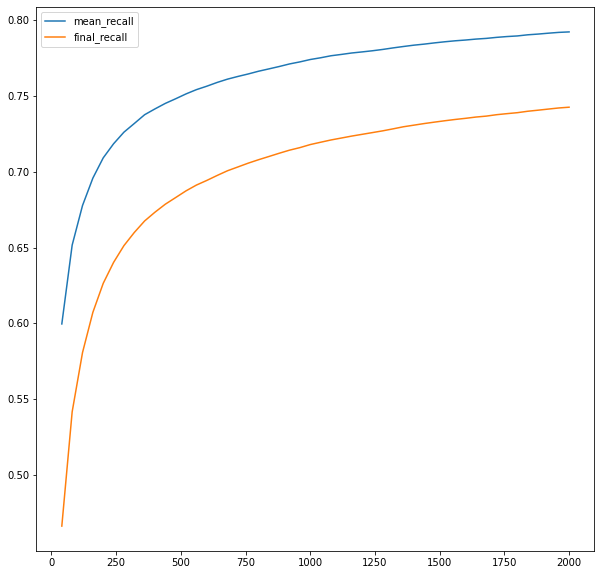

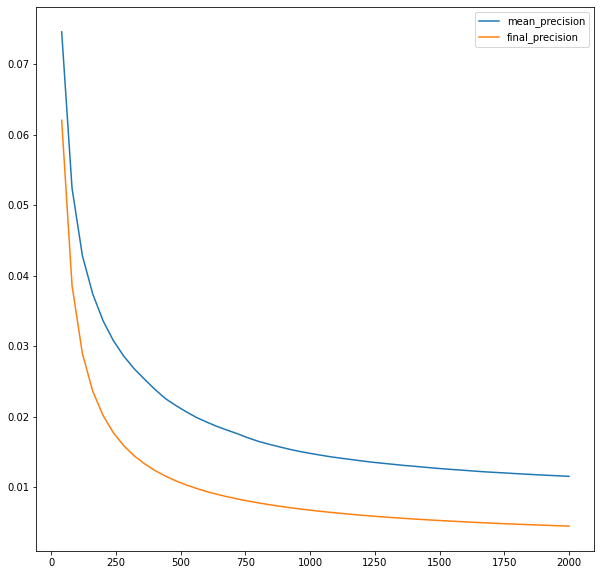

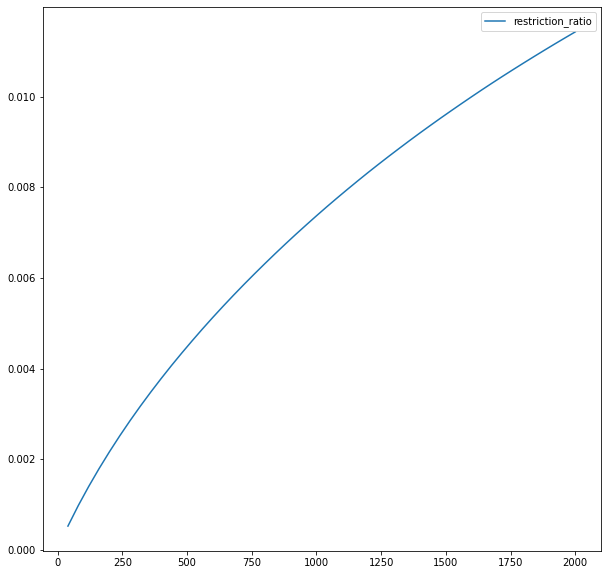

NameError: ignored

In [ ]:
compute_intersection_recall_vals_zip("overshoot_small_trained_in_train_eval_test.zip", topk_vals = (np.arange(50)+1)*40)

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fb77d9c11c0>)
0     time:  1.8460216522216797
3000     time:  7.03061056137085
6000     time:  3.72599720954895
9000     time:  3.616805076599121
12000     time:  3.9355454444885254
15000     time:  3.853652238845825
18000     time:  3.700155735015869
21000     time:  3.888319253921509
24000     time:  3.802574396133423
27000     time:  3.705862045288086
30000     time:  3.744626760482788
33000     time:  3.8818893432617188
36000     time:  3.84232759475708
39000     time:  3.8259572982788086
42000     time:  3.8779876232147217
45000     time:  3.7376997470855713
48000     time:  3.8634493350982666
51000     time:  3.8048274517059326
54000     time:  3.8153371810913086
57000     time:  3.939267158508301
60000     time:  4.5624918937683105
63000     time:  4.106829643249512
66000     time:  3.9766626358032227
69000     time:  3.8980400562286377
72000     time:  3.8181352615356445
75000     time:  3.8895089626312256
Computed metrics of 0 out

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
2,0.321043,0.289466,0.999918,0.185295,0.115589,0.285032,0.131186,0.999918,0.000028
4,0.380992,0.240252,0.999901,0.216352,0.180520,0.229805,0.188610,0.999901,0.000055
6,0.421237,0.208873,0.999882,0.228414,0.228211,0.198146,0.221489,0.999882,0.000080
8,0.450629,0.185925,0.999862,0.233107,0.264910,0.175613,0.240456,0.999862,0.000105
10,0.474134,0.170768,0.999842,0.236216,0.295150,0.158966,0.251977,0.999842,0.000129
12,0.493379,0.157257,0.999822,0.235642,0.320030,0.145533,0.258130,0.999822,0.000153
14,0.509033,0.146554,0.999801,0.233831,0.340631,0.134172,0.260471,0.999801,0.000177
16,0.522592,0.137591,0.999780,0.231478,0.358839,0.124874,0.261027,0.999780,0.000200
18,0.534033,0.129825,0.999759,0.228324,0.375069,0.117001,0.260259,0.999759,0.000223
20,0.544651,0.123305,0.999738,0.225567,0.389624,0.110249,0.258576,0.999738,0.000246


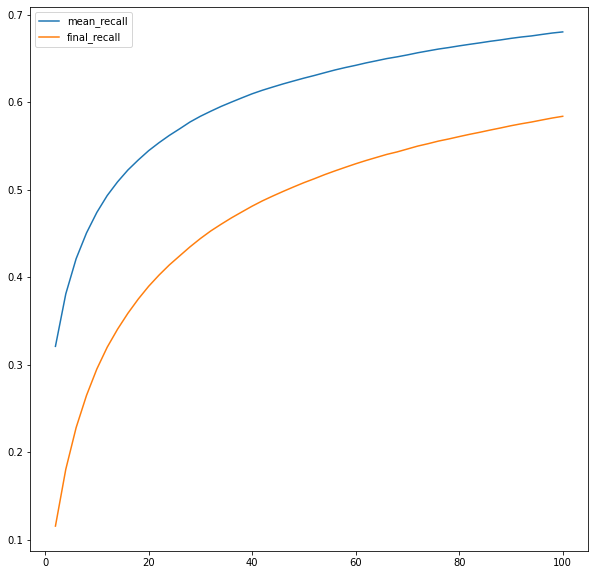

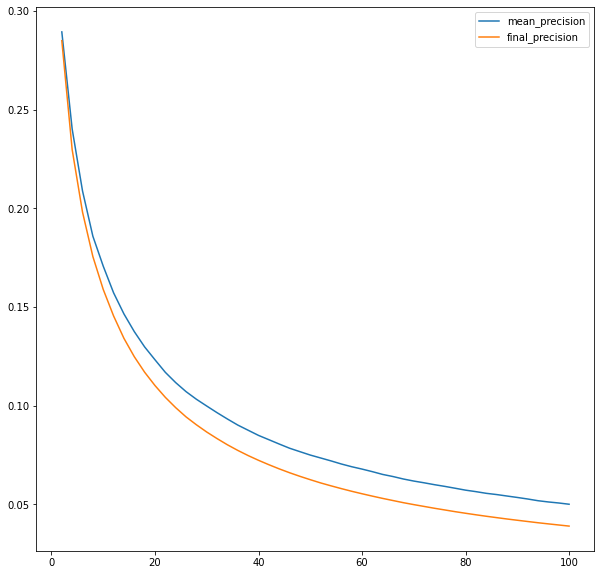

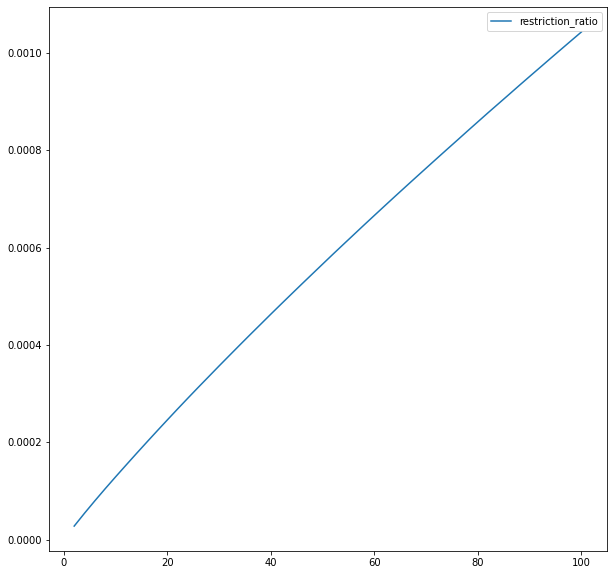

In [ ]:
compute_intersection_recall_vals_zip("precise_best_trained_on_train_eval_test.zip", topk_vals = (np.arange(50)+1)*2)

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fb78e038310>)
0     time:  0.48338890075683594
3000     time:  3.987776041030884
6000     time:  3.7635109424591064
9000     time:  3.643343687057495
12000     time:  3.8625903129577637
15000     time:  4.101367235183716
18000     time:  3.940004587173462
21000     time:  3.82999849319458
24000     time:  3.982473611831665
27000     time:  3.770585536956787
30000     time:  3.8355355262756348
33000     time:  3.970520496368408
36000     time:  3.903369188308716
39000     time:  3.8733317852020264
42000     time:  3.9298641681671143
45000     time:  3.997075319290161
48000     time:  3.807482957839966
51000     time:  3.7903594970703125
54000     time:  3.871321678161621
57000     time:  3.8129427433013916
60000     time:  3.7107200622558594
63000     time:  3.995168685913086
66000     time:  3.7633633613586426
69000     time:  3.751267194747925
72000     time:  3.938292980194092
75000     time:  4.003981590270996
Computed metrics of 0 out 

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
40,0.609702,0.084982,0.999534,0.195649,0.481272,0.072361,0.225928,0.999534,0.000464
80,0.664480,0.057234,0.999150,0.156097,0.560777,0.045524,0.171825,0.999150,0.000859
120,0.692929,0.045015,0.998794,0.133404,0.602483,0.034400,0.140022,0.998794,0.001221
160,0.712854,0.038064,0.998458,0.118754,0.631501,0.028210,0.119667,0.998458,0.001560
200,0.727663,0.033193,0.998140,0.107840,0.652829,0.024189,0.105332,0.998140,0.001881
240,0.737873,0.029830,0.997838,0.099433,0.668100,0.021307,0.094482,0.997838,0.002186
280,0.746851,0.027335,0.997549,0.092933,0.680878,0.019163,0.086121,0.997549,0.002476
320,0.753719,0.025164,0.997271,0.087276,0.690992,0.017479,0.079366,0.997271,0.002755
360,0.760528,0.023320,0.997004,0.082576,0.700086,0.016139,0.073883,0.997004,0.003023
400,0.765251,0.021790,0.996747,0.078516,0.707040,0.015018,0.069209,0.996747,0.003281


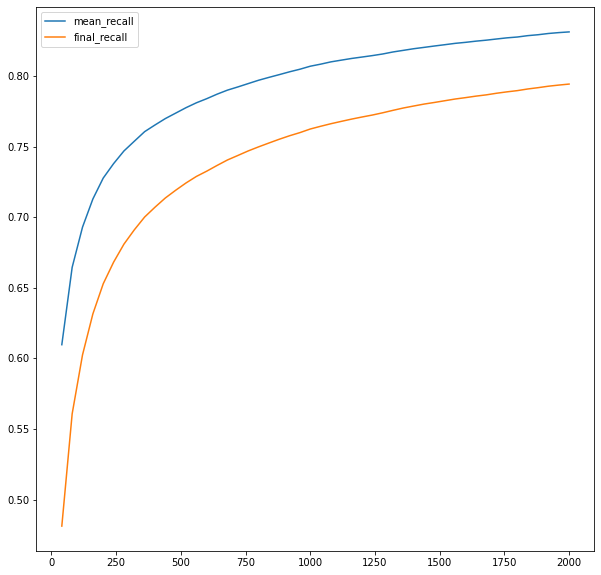

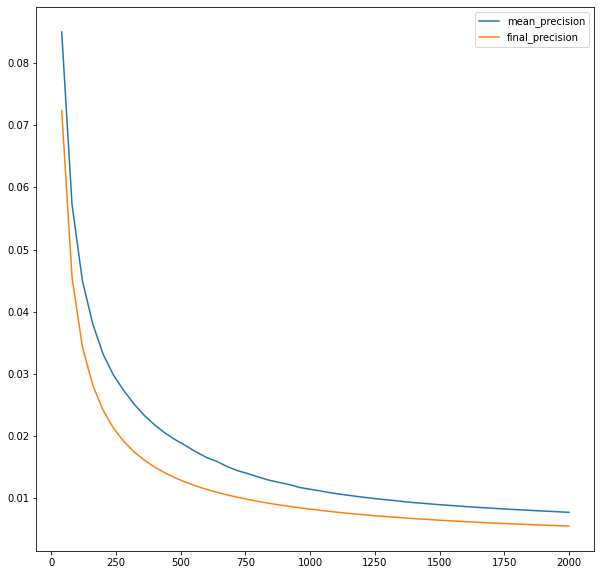

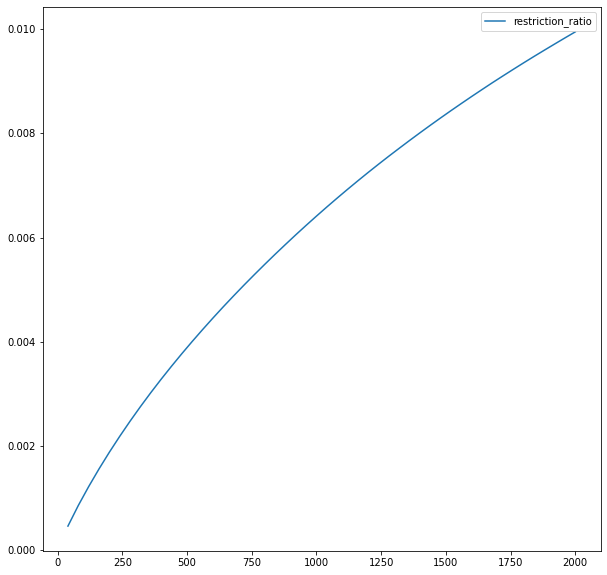

In [ ]:
compute_intersection_recall_vals_zip("precise_best_trained_on_train_eval_test.zip", topk_vals = (np.arange(50)+1)*40)

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f6c604f7e80>)
0     time:  0.2129061222076416
3000     time:  3.761582612991333
6000     time:  3.564301013946533
9000     time:  3.77620267868042
12000     time:  3.7611751556396484
15000     time:  3.7195699214935303
18000     time:  3.607374429702759
21000     time:  3.67205548286438
24000     time:  3.70269775390625
27000     time:  3.734647750854492
30000     time:  3.74173641204834
33000     time:  3.836581230163574
36000     time:  3.7985265254974365
39000     time:  3.771548271179199
42000     time:  3.8059921264648438
45000     time:  3.8327395915985107
48000     time:  4.453634738922119
51000     time:  4.280280113220215
54000     time:  3.9202280044555664
57000     time:  4.106353998184204
60000     time:  3.884378671646118
63000     time:  4.234140634536743
66000     time:  4.409047842025757
69000     time:  4.137563705444336
72000     time:  3.9055862426757812
75000     time:  3.98846697807312
Computed metrics of 0 out of 2533

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
2,0.299606,0.256788,0.999917,0.163953,0.098693,0.252388,0.112380,0.999917,0.000027
4,0.353105,0.215589,0.999900,0.189170,0.157729,0.208605,0.165817,0.999900,0.000053
6,0.389954,0.191002,0.999881,0.202671,0.201423,0.181714,0.197147,0.999881,0.000077
8,0.417044,0.173275,0.999862,0.209565,0.235498,0.162118,0.215949,0.999862,0.000101
10,0.437980,0.158572,0.999842,0.212075,0.263003,0.146939,0.227123,0.999842,0.000125
12,0.456138,0.147303,0.999823,0.213254,0.286722,0.135352,0.234314,0.999823,0.000148
14,0.471651,0.138091,0.999803,0.213163,0.306798,0.125619,0.238112,0.999803,0.000170
16,0.485156,0.130494,0.999783,0.212339,0.324966,0.117765,0.240379,0.999783,0.000192
18,0.496795,0.123764,0.999764,0.210929,0.340964,0.110882,0.240963,0.999764,0.000214
20,0.507279,0.117811,0.999744,0.208992,0.355589,0.104985,0.240684,0.999744,0.000236


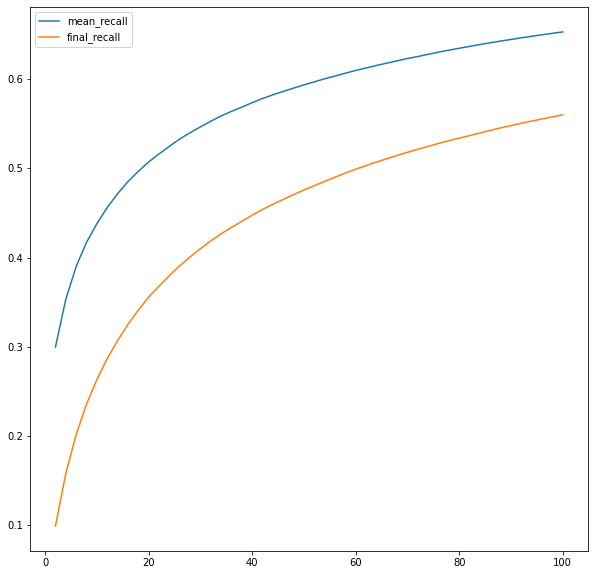

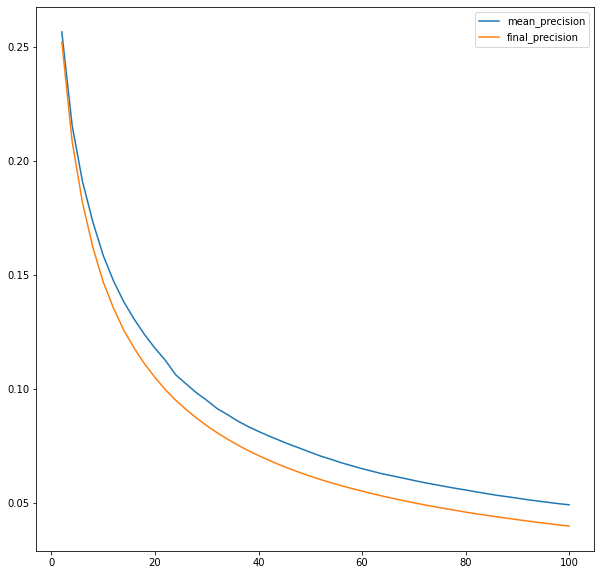

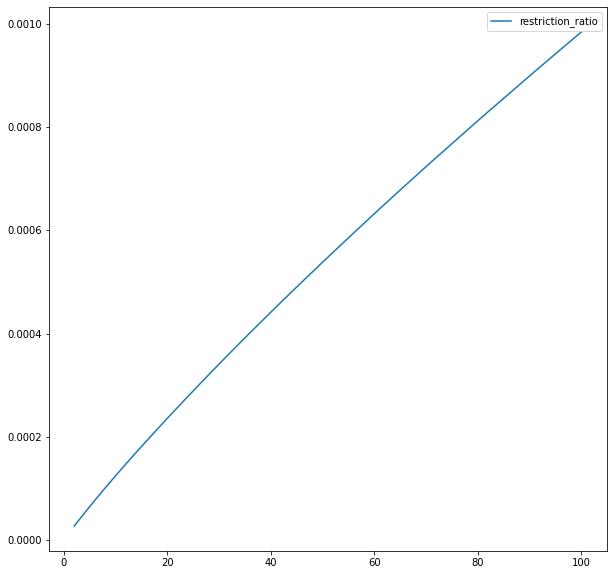

In [ ]:
compute_intersection_recall_vals_zip("precise_best_trained_on_train_eval_test.zip", topk_vals = (np.arange(50)+1)*2,
                                     topk_mpnet_restriction_file = "GENERATED_TOPK_PREDS_FROM_MPNET_TREE.npy")

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f6c61c27670>)
0     time:  0.20812058448791504
3000     time:  3.736093282699585
6000     time:  3.6433322429656982
9000     time:  3.586775302886963
12000     time:  3.8025946617126465
15000     time:  3.8629157543182373
18000     time:  3.7882916927337646
21000     time:  3.6914548873901367
24000     time:  3.7478623390197754
27000     time:  3.6811039447784424
30000     time:  3.797917127609253
33000     time:  3.7747106552124023
36000     time:  3.751112699508667
39000     time:  3.7796781063079834
42000     time:  3.75424861907959
45000     time:  3.674024820327759
48000     time:  3.6653695106506348
51000     time:  3.690746545791626
54000     time:  3.606440544128418
57000     time:  3.6724417209625244
60000     time:  3.7845821380615234
63000     time:  3.8203113079071045
66000     time:  3.7272520065307617
69000     time:  3.803475856781006
72000     time:  3.785250663757324
75000     time:  3.774782657623291
Computed metrics of 0

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
2,0.319660,0.307562,0.999920,0.201991,0.114398,0.303690,0.130690,0.999920,0.000026
4,0.378288,0.260600,0.999905,0.232256,0.178178,0.246475,0.188632,0.999905,0.000050
6,0.417698,0.232345,0.999888,0.246140,0.225143,0.213632,0.222742,0.999888,0.000073
8,0.446549,0.210072,0.999871,0.250743,0.261206,0.190125,0.243034,0.999871,0.000096
10,0.469503,0.195259,0.999853,0.253532,0.290850,0.172731,0.255857,0.999853,0.000117
12,0.488137,0.182593,0.999836,0.253687,0.315095,0.158531,0.263123,0.999836,0.000139
14,0.503323,0.171916,0.999818,0.251996,0.335191,0.146627,0.266616,0.999818,0.000159
16,0.516364,0.162632,0.999800,0.249332,0.352834,0.136772,0.268122,0.999800,0.000180
18,0.527442,0.155004,0.999782,0.246651,0.368711,0.128544,0.268413,0.999782,0.000200
20,0.537625,0.148507,0.999764,0.243940,0.382811,0.121446,0.267621,0.999764,0.000220


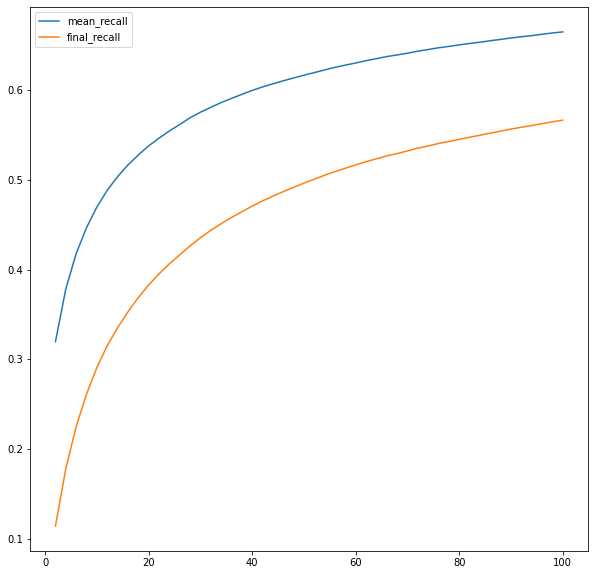

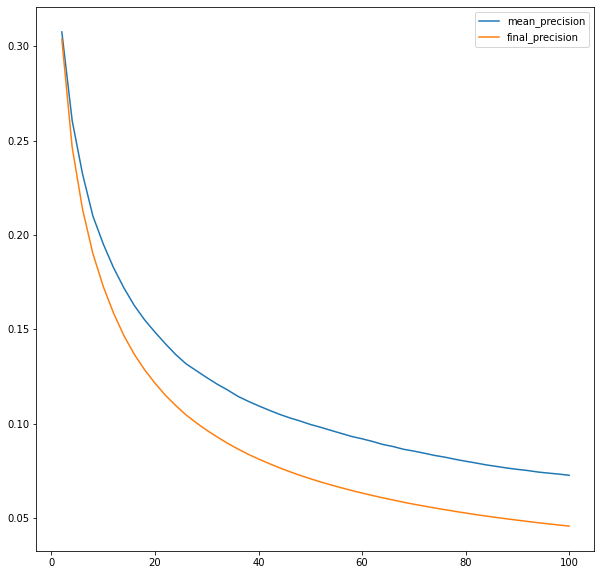

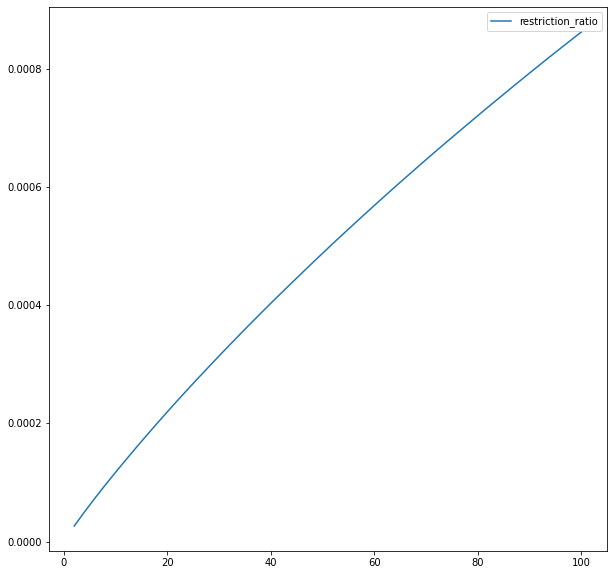

In [ ]:
compute_intersection_recall_vals_zip_double("precise_best_trained_on_train_eval_test.zip", topk_vals = (np.arange(50)+1)*2)

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f6c5d7d9a30>)
0     time:  0.7283370494842529
3000     time:  4.1544506549835205
6000     time:  4.066988229751587
9000     time:  3.9196646213531494
12000     time:  4.18459939956665
15000     time:  4.144272089004517
18000     time:  4.069279909133911
21000     time:  4.105523347854614
24000     time:  4.083435773849487
27000     time:  4.101752758026123
30000     time:  4.124871253967285
33000     time:  4.132938385009766
36000     time:  4.165963649749756
39000     time:  4.140536785125732
42000     time:  4.078113079071045
45000     time:  4.111862659454346
48000     time:  4.0757060050964355
51000     time:  3.940134286880493
54000     time:  4.121889591217041
57000     time:  4.12698221206665
60000     time:  3.9672842025756836
63000     time:  4.225658416748047
66000     time:  4.063364028930664
69000     time:  4.076773643493652
72000     time:  3.9915802478790283
75000     time:  4.276721715927124
Computed metrics of 0 out of 253

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
80,0.661061,0.065042,0.999192,0.163670,0.557103,0.047571,0.177298,0.999192,0.000816
160,0.708140,0.042992,0.998555,0.124834,0.626273,0.029837,0.125305,0.998555,0.001463
240,0.732074,0.033970,0.998000,0.105570,0.661660,0.022800,0.100191,0.998000,0.002023
320,0.747160,0.029061,0.997506,0.093826,0.683563,0.018911,0.085136,0.997506,0.002519
400,0.757889,0.025400,0.997062,0.085240,0.698693,0.016423,0.075057,0.997062,0.002965
480,0.765561,0.022818,0.996658,0.078640,0.709866,0.014677,0.067778,0.996658,0.003371
560,0.772101,0.020834,0.996286,0.073389,0.718890,0.013382,0.062275,0.996286,0.003744
640,0.777647,0.019200,0.995942,0.069132,0.726036,0.012375,0.057925,0.995942,0.004089
720,0.782312,0.017736,0.995622,0.065439,0.732546,0.011576,0.054439,0.995622,0.004411
800,0.786421,0.016587,0.995322,0.062351,0.737936,0.010918,0.051539,0.995322,0.004711


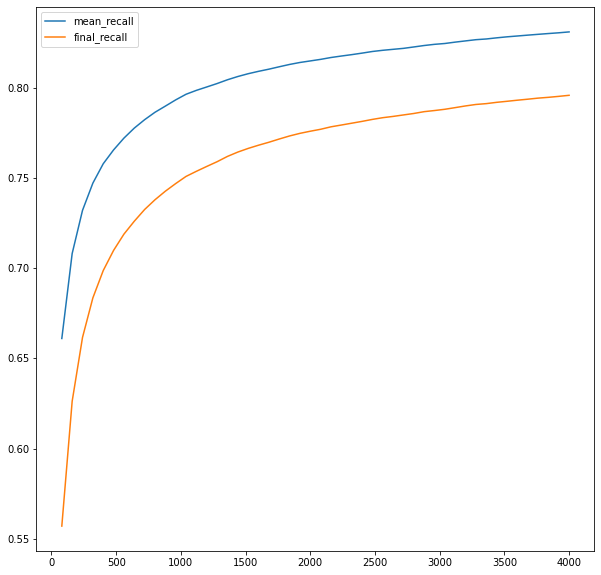

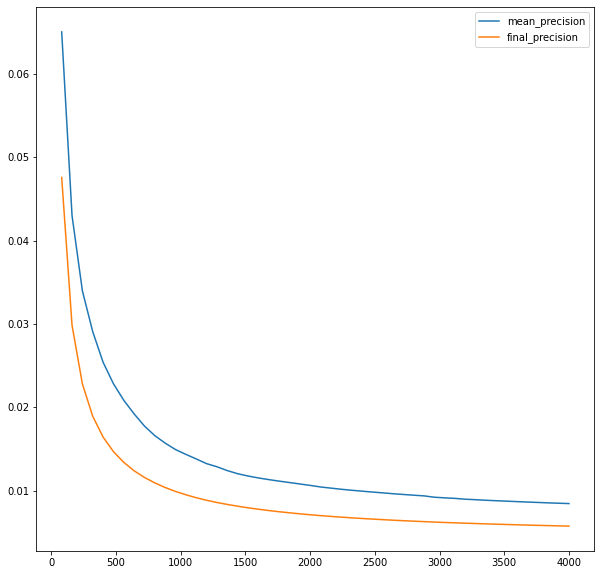

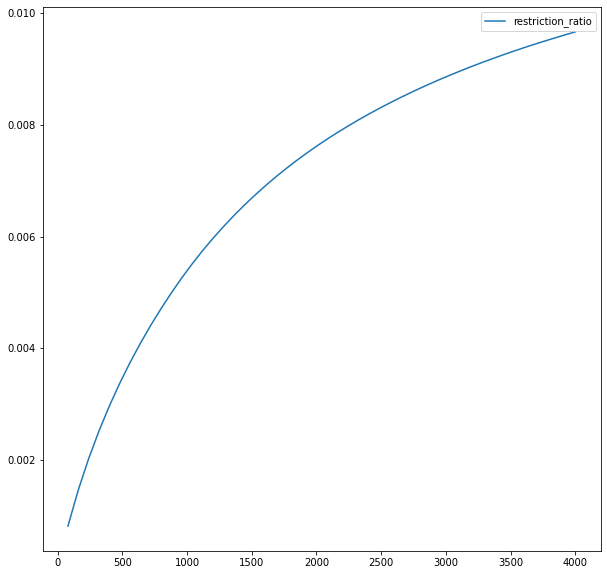

In [ ]:
compute_intersection_recall_vals_zip_double("precise_best_trained_on_train_eval_test.zip", topk_vals = (np.arange(50)+1)*80)

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f6c5c6e63d0>)
0     time:  0.19676923751831055
3000     time:  3.6773934364318848
6000     time:  3.6195240020751953
9000     time:  3.45324444770813
12000     time:  3.616394519805908
15000     time:  3.6492819786071777
18000     time:  3.723813772201538
21000     time:  3.5818421840667725
24000     time:  3.6234781742095947
27000     time:  4.061111211776733
30000     time:  3.9977805614471436
33000     time:  3.6875550746917725
36000     time:  3.718717575073242
39000     time:  3.7814714908599854
42000     time:  3.6552019119262695
45000     time:  3.551926851272583
48000     time:  3.6009979248046875
51000     time:  3.625079870223999
54000     time:  3.53975772857666
57000     time:  3.6540768146514893
60000     time:  3.6669375896453857
63000     time:  3.6755082607269287
66000     time:  3.6037518978118896
69000     time:  3.690624237060547
72000     time:  3.6212806701660156
75000     time:  3.7025039196014404
Computed metrics of 

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
80,0.664476,0.057233,0.999150,0.156095,0.560767,0.045523,0.171822,0.999150,0.000859
160,0.712854,0.038064,0.998458,0.118754,0.631501,0.028210,0.119667,0.998458,0.001560
240,0.737873,0.029830,0.997838,0.099433,0.668100,0.021307,0.094482,0.997838,0.002186
320,0.753705,0.025164,0.997271,0.087275,0.690982,0.017479,0.079365,0.997271,0.002755
400,0.765251,0.021790,0.996747,0.078516,0.707040,0.015018,0.069209,0.996747,0.003281
480,0.773648,0.019422,0.996259,0.071755,0.719051,0.013287,0.061863,0.996259,0.003772
560,0.780962,0.017465,0.995799,0.066205,0.728822,0.012000,0.056292,0.995799,0.004233
640,0.787074,0.015951,0.995362,0.061771,0.736614,0.010992,0.051863,0.995362,0.004671
720,0.792155,0.014464,0.994947,0.057767,0.743639,0.010189,0.048298,0.994947,0.005087
800,0.796888,0.013456,0.994550,0.054587,0.749735,0.009528,0.045334,0.994550,0.005485


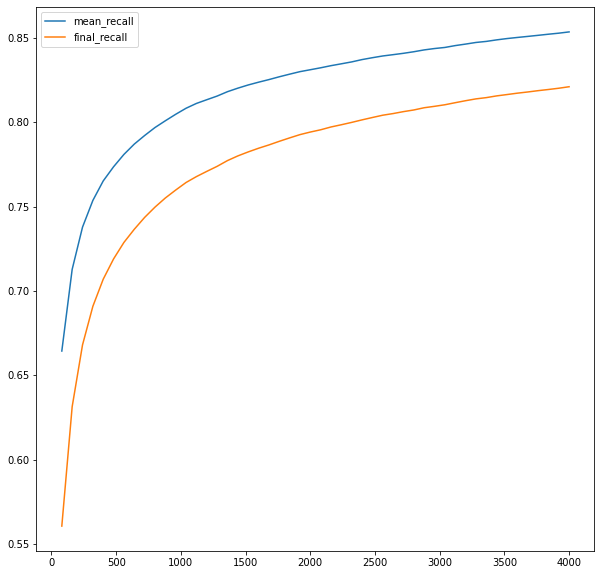

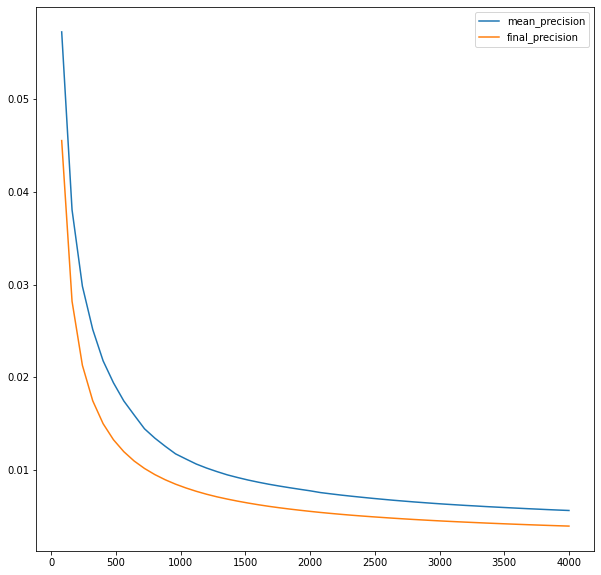

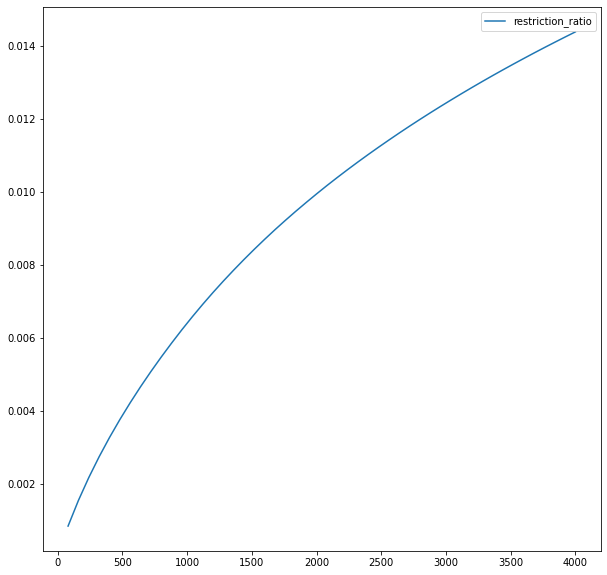

In [ ]:
compute_intersection_recall_vals_zip("precise_best_trained_on_train_eval_test.zip", topk_vals = (np.arange(50)+1)*80)